In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_graph(bars, labels, title):
    """
    Plota gráficos de barras lado a lado.

    Args:
        bars (list): Lista de vetores com os valores das barras.
        labels (list): Lista de rótulos para as barras.
        title (str): Título do gráfico.
    """
    # Número de barras e rótulos
    num_bars = len(bars)
    num_labels = len(labels)

    # Verificar se o número de barras e rótulos é o mesmo
    if num_bars != num_labels:
        raise ValueError("O número de barras deve ser igual ao número de rótulos.")

    # Rótulos para as barras
    r = np.arange(len(bars[0]))

    # Largura das barras
    bar_width = 1 / (num_bars + 1)

    # Cores para as barras
    colors = ['red', 'green', 'blue', 'orange', 'yellon']

    # Monta o gráfico de barras
    for i in range(num_labels):
        plt.bar(r + i * bar_width, bars[i], color=colors[i], width=bar_width,
                edgecolor='white', label=labels[i])

    # Adicionar rótulos, título e legenda ao gráfico
    plt.xlabel('Operações CRUD')
    plt.ylabel('Valores')
    plt.title(title)
    plt.xticks(r + (num_bars - 1) * bar_width / 2, ['Insert', 'Read', 'Update', 'Delete'])
    plt.legend()

    plt.show()


In [2]:
import pandas as pd
import re

# Definindo a função para processar o texto em DataFrame
def process_benchmark_data(text):
    data = []
    current_class = None

    # Percorre cada linha do texto
    for line in text.splitlines():
        # Verifica se é uma linha de título de classe
        if line.startswith('Class'):
            current_class = line.strip()
        else:
            # Extrai os dados usando regex
            match = re.match(r'Benchmark(\w+)-\d+\s+(\d+)\s+(\d+) ns/op\s+(\d+) B/op\s+(\d+) allocs/op', line)
            if match:
                operation = match.group(1)
                ops = int(match.group(2))
                ns_per_op = int(match.group(3))
                b_per_op = int(match.group(4))
                allocs_per_op = int(match.group(5))
                data.append([current_class, operation, ops, ns_per_op, b_per_op, allocs_per_op])
    
    # Cria o DataFrame
    df = pd.DataFrame(data, columns=['methodology', 'operation', 'ops', 'time_per_op', 'bytes_per_op', 'allocs_per_op'])
    
    # Agrupa os dados pela metodologia e operação, calculando a média
    grouped_summary = df.groupby(['methodology', 'operation']).mean().reset_index()
    return grouped_summary

In [3]:
# Dados obtidos dos testes
benchmark_text = """
ClassWithGorm
BenchmarkInsertClass-8   	     122	   9318648 ns/op	   12567 B/op	     168 allocs/op
BenchmarkReadClass-8     	     444	   2260651 ns/op	   19143 B/op	     217 allocs/op
BenchmarkUpdateClass-8   	     279	   4507626 ns/op	    6337 B/op	      79 allocs/op
BenchmarkDeleteClass-8   	     135	   9172396 ns/op	   12192 B/op	     165 allocs/op

ClassOneQuery
BenchmarkInsertClass-8   	     147	   7592175 ns/op	    1647 B/op	      35 allocs/op
BenchmarkReadClass-8     	     459	   2562340 ns/op	    1592 B/op	      44 allocs/op
BenchmarkUpdateClass-8   	     350	   3677126 ns/op	     414 B/op	      13 allocs/op
BenchmarkDeleteClass-8   	     165	   7034611 ns/op	    1564 B/op	      34 allocs/op

ClassDAO
BenchmarkInsertClass-8   	     153	   7556331 ns/op	    2070 B/op	      52 allocs/op
BenchmarkReadClass-8     	     279	   4226610 ns/op	    2385 B/op	      70 allocs/op
BenchmarkUpdateClass-8   	     370	   3328781 ns/op	     625 B/op	      24 allocs/op
BenchmarkDeleteClass-8   	     182	   6730914 ns/op	    1991 B/op	      52 allocs/op

ClassSQLRepository
BenchmarkInsertClass-8   	     152	   7517927 ns/op	    2009 B/op	      49 allocs/op
BenchmarkReadClass-8     	     529	   2150848 ns/op	    1048 B/op	      33 allocs/op
BenchmarkUpdateClass-8   	     366	   3430687 ns/op	     651 B/op	      22 allocs/op
BenchmarkDeleteClass-8   	     176	   6883016 ns/op	    1923 B/op	      48 allocs/op
"""

In [4]:
from tabulate import tabulate
# Processando os dados
grouped_summary = process_benchmark_data(benchmark_text)
print(tabulate(grouped_summary, headers='keys', tablefmt='pretty'))

+----+--------------------+-------------+-------+-------------+--------------+---------------+
|    |    methodology     |  operation  |  ops  | time_per_op | bytes_per_op | allocs_per_op |
+----+--------------------+-------------+-------+-------------+--------------+---------------+
| 0  |      ClassDAO      | DeleteClass | 182.0 |  6730914.0  |    1991.0    |     52.0      |
| 1  |      ClassDAO      | InsertClass | 153.0 |  7556331.0  |    2070.0    |     52.0      |
| 2  |      ClassDAO      |  ReadClass  | 279.0 |  4226610.0  |    2385.0    |     70.0      |
| 3  |      ClassDAO      | UpdateClass | 370.0 |  3328781.0  |    625.0     |     24.0      |
| 4  |   ClassOneQuery    | DeleteClass | 165.0 |  7034611.0  |    1564.0    |     34.0      |
| 5  |   ClassOneQuery    | InsertClass | 147.0 |  7592175.0  |    1647.0    |     35.0      |
| 6  |   ClassOneQuery    |  ReadClass  | 459.0 |  2562340.0  |    1592.0    |     44.0      |
| 7  |   ClassOneQuery    | UpdateClass | 350.0 | 

In [5]:
# Função para extrair dados e evitar arrays vazios
def extract_data(df, class_name, attribute_benchmark):
    insert = df[(df['methodology'] == class_name) & (df['operation'] == 'InsertClass')][attribute_benchmark].values
    read = df[(df['methodology'] == class_name) & (df['operation'] == 'ReadClass')][attribute_benchmark].values
    update = df[(df['methodology'] == class_name) & (df['operation'] == 'UpdateClass')][attribute_benchmark].values
    delete = df[(df['methodology'] == class_name) & (df['operation'] == 'DeleteClass')][attribute_benchmark].values
    return [np.mean(insert) if insert.size > 0 else np.nan,
            np.mean(read) if read.size > 0 else np.nan,
            np.mean(update) if update.size > 0 else np.nan,
            np.mean(delete) if delete.size > 0 else np.nan]

In [6]:
def plot_per(attribute_benchmark):
    # Extraindo os dados para o gráfico
    insert_dao, read_dao, update_dao, delete_dao = extract_data(grouped_summary, 'ClassDAO', attribute_benchmark)
    insert_onequery, read_onequery, update_onequery, delete_onequery = extract_data(grouped_summary, 'ClassOneQuery', attribute_benchmark)
    insert_gorm, read_gorm, update_gorm, delete_gorm = extract_data(grouped_summary, 'ClassWithGorm', attribute_benchmark)
    insert_sql, read_sql, update_sql, delete_sql = extract_data(grouped_summary, 'ClassSQLRepository', attribute_benchmark)

    # Dados para o gráfico
    bars = [
        [insert_dao, read_dao, update_dao, delete_dao],
        [insert_onequery, read_onequery, update_onequery, delete_onequery],
        [insert_gorm, read_gorm, update_gorm, delete_gorm],
        [insert_sql, read_sql, update_sql, delete_sql]
    ]

    labels = ['DAO', 'OneQuery', 'GORM', 'SQLRepository']
    title = 'Benchmark CRUD ' + attribute_benchmark

    # Plotar o gráfico
    plot_bar_graph(bars, labels, title)

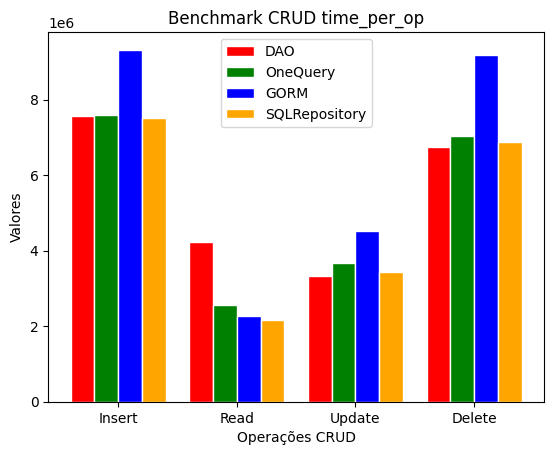

In [7]:
plot_per('time_per_op')

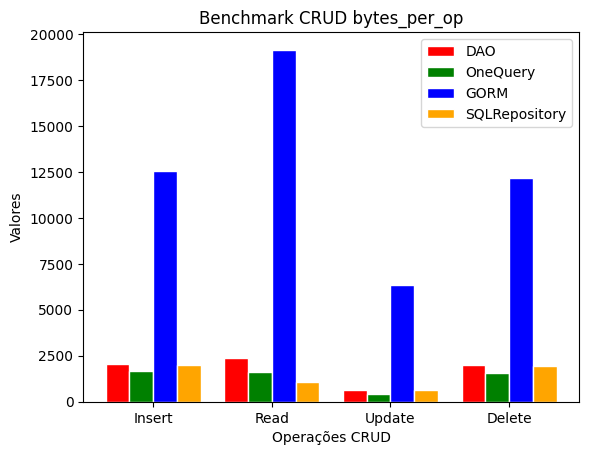

In [8]:
plot_per('bytes_per_op')

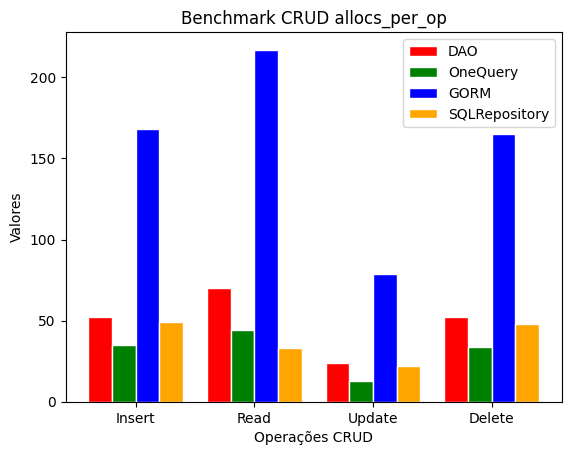

In [9]:
plot_per('allocs_per_op')